# Example SN Injection and Recovery

This is an example supernova injection and recovery to use in my poster.

In [356]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

from lightkurve import KeplerTargetPixelFile
import numpy as np
import matplotlib.pyplot as plt
from lightkurve.injection import SupernovaModel
import lightkurve.injection as inj
import scipy.optimize as op

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [357]:
tpf = KeplerTargetPixelFile.from_archive(220381074) 

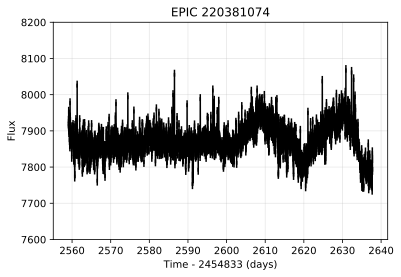

In [358]:
lc = tpf.to_lightcurve(aperture_mask='all') 
lc = lc.remove_nans().remove_outliers() 
lc.plot(normalize=False)
plt.ylim(7600, 8200)
plt.title('EPIC 220381074')
plt.savefig('/Users/sheilasagear/supernovae/plots/galaxy')

In [359]:
model = inj.SupernovaModel(T0=2600, source='hsiao', bandpass='kepler', z=0.5, amplitude=2.e-7)
lcinj = inj.inject(lc, model)
lcinj = lcinj.remove_nans()

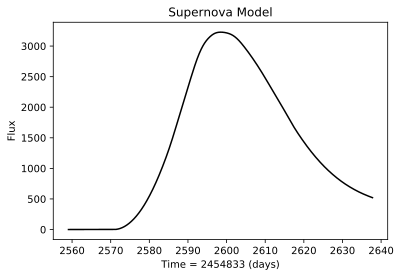

In [360]:
model_sn_eval = model.evaluate(lc.time)
plt.plot(lc.time, model_sn_eval, c='k')
plt.title('Supernova Model')
plt.xlabel('Time = 2454833 (days)')
plt.ylabel('Flux')
plt.savefig('/Users/sheilasagear/supernovae/plots/sn_plain_model')

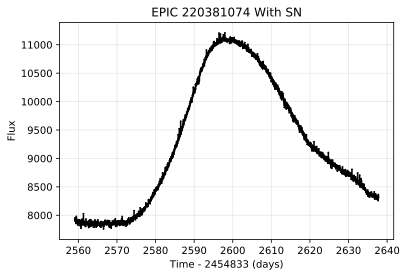

In [361]:
%config InlineBackend.figure_format = 'svg'
lcinj.plot(normalize=False)
plt.title('EPIC 220381074 With SN')
plt.savefig('/Users/sheilasagear/supernovae/plots/sn_injected')

In [362]:
def ln_like(theta):
    T0, z, amplitude, background = theta
    if (z < 0) or (z > 1) or (T0 < np.min(lc.time)) or (T0 > np.max(lc.time)):
        return -1.e99
    model = SupernovaModel(T0, z=z, amplitude=amplitude, bandpass='kepler')
    model = model.evaluate(lcinj.time) + background
    inv_sigma2 = 1.0/(lcinj.flux_err**2)
    chisq = (np.sum((lcinj.flux-model)**2*inv_sigma2))
    lnlikelihood = -0.5*chisq
    return lnlikelihood


def neg_ln_like(theta):
    return -1 * ln_like(theta)


In [363]:
def lnprior(theta):
    T0, z, amplitude, background = theta
    if z < 0 or z > 1:
        return -np.inf
    return 0.0

In [364]:
def lnprior_optimization(theta):
    T0, z, amplitude, background = theta
    if (z < 0) or (z > 1):
        return -1.e99
    return 0.0

In [365]:
def lnprob(theta):
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + ln_like(theta)

In [366]:
def ln_posterior(theta):
    lp = lnprior(theta)
    return lp + ln_like(theta)

In [367]:
def neg_ln_posterior(theta):
    log_posterior = lnprior_optimization(theta) + ln_like(theta)
    return -1 * log_posterior

In [368]:
%%time

#Injected values: T0=2600, z=0.5, amplitude=1e-7
x0 = [2610, 0.5, 2.0e-7, np.percentile(lc.flux, 3)]

result = op.minimize(neg_ln_posterior, x0)

CPU times: user 2min 16s, sys: 14 s, total: 2min 30s
Wall time: 1min 24s


In [369]:
print(result)
T0_f, z_f, amplitude_f, background_f = result["x"]

      fun: 126157.51623236734
 hess_inv: array([[ 1.12411384e-05,  9.82378663e-07, -8.25787548e-14,
        -1.83841193e-05],
       [ 9.82378663e-07,  1.17499912e-07, -8.30844442e-15,
        -1.61476425e-05],
       [-8.25787548e-14, -8.30844442e-15,  1.35328390e-21,
        -4.95733134e-12],
       [-1.83841193e-05, -1.61476425e-05, -4.95733134e-12,
         7.36774035e-02]])
      jac: array([-8.46601465e+03, -2.61239356e+05,  1.47829593e+13,  8.85396484e+02])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 678
      nit: 8
     njev: 111
   status: 2
  success: False
        x: array([2.59958824e+03, 4.34687649e-01, 1.90462762e-07, 7.98950637e+03])


In [370]:
new_model = inj.SupernovaModel(T0=T0_f, source='hsiao', bandpass='kepler', z=z_f, amplitude=amplitude_f)
new_fit = new_model.evaluate(lc.time) + background_f

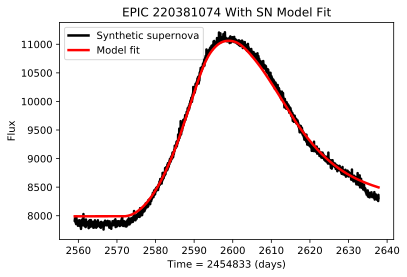

In [371]:
plt.plot(lcinj.time, lcinj.flux, label='Synthetic supernova', color='k', lw='2.5')
plt.plot(lcinj.time, new_fit, label = 'Model fit', color='r', lw='2.5')
plt.legend()
plt.title('EPIC 220381074 With SN Model Fit')
plt.xlabel('Time = 2454833 (days)')
plt.ylabel('Flux')
%config InlineBackend.figure_format = 'svg'
plt.savefig('/Users/sheilasagear/supernovae/plots/sn_modelfit')

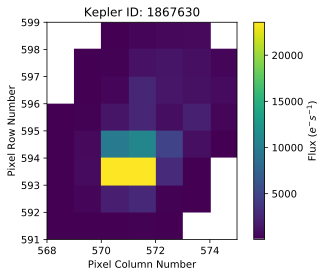

In [341]:
tpf_gtype = KeplerTargetPixelFile.from_archive(1867630, quarter=1)
lc = tpf_gtype.to_lightcurve(aperture_mask='all')

#Remove nans and outliers
lc = lc.remove_nans().remove_outliers()

tpf_gtype.plot();

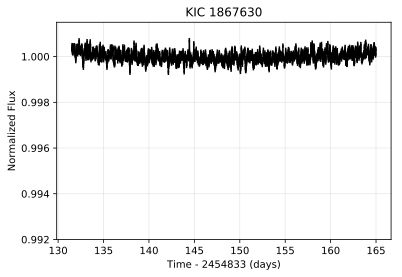

In [349]:
lc.plot();
plt.title('KIC 1867630')
plt.ylim(.992, 1.0015);
plt.savefig('/Users/sheilasagear/supernovae/plots/gtype_star')

In [350]:
planet_model = inj.TransitModel()
planet_model.add_star()
planet_model.add_planet(5, 0.08, 133.5)
lc_transit = inj.inject(lc, planet_model)

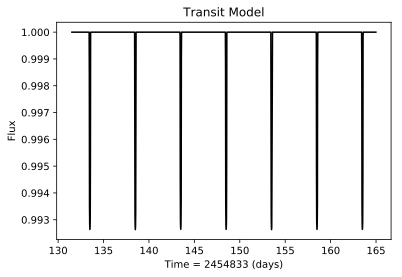

In [353]:
planet_model_eval = planet_model.evaluate(lc.time)
plt.plot(lc.time, planet_model_eval, c='k')
plt.title('Transit Model')
plt.xlabel('Time = 2454833 (days)')
plt.ylabel('Flux')
plt.savefig('/Users/sheilasagear/supernovae/plots/transit_model')

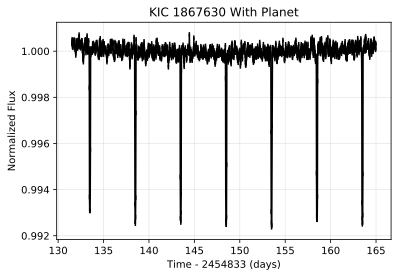

In [320]:
lc_transit.plot()
plt.title('KIC 1867630 With Planet')
plt.savefig('/Users/sheilasagear/supernovae/plots/transit_injected')

In [280]:
def ln_like(theta):
    period, rprs, T0 = theta
    model = inj.TransitModel()
    model.add_star()
    model.add_planet(period, rprs, T0)
    model = model.evaluate(lc_transit.time)
    inv_sigma2 = 1.0/(lc_transit.flux_err**2)
    chisq = (np.sum((lc_transit.flux-model)**2*inv_sigma2))
    lnlikelihood = -0.5*chisq
    return lnlikelihood


def neg_ln_like(theta):
    return -1 * ln_like(theta)


In [281]:
print(ln_like([5, 0.1, 131]))

-82238163525.52731


In [288]:
def lnprior(theta):
    period, rprs, T0 = theta
    if period < 0.0 or period > 26.0:
        return -np.inf
    return 0.0

In [283]:
def lnprior_optimization(theta):
    period, rprs, T0 = theta
    if period < 0.0 or period > 26.0:
        return -1.e99
    return 0.0

In [284]:
def lnprob(theta):
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + ln_like(theta)

In [285]:
def ln_posterior(theta):
    lp = lnprior(theta)
    return lp + ln_like(theta)

In [286]:
def neg_ln_posterior(theta):
    log_posterior = lnprior_optimization(theta) + ln_like(theta)
    return -1 * log_posterior

In [287]:
%%time

#Injected values: planet_model.add_planet(5, 0.1, 133.5)
x0 = [4.5, 0.5, 130]

result = op.minimize(neg_ln_posterior, x0)
print(result)
period_f, rprs_f, T0_f = result["x"]

      fun: nan
 hess_inv: array([[1, 0, 0],
       [0, 1, 0],
       [0, 0, 1]])
      jac: array([nan, nan, nan])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 5
      nit: 0
     njev: 1
   status: 2
  success: False
        x: array([  4.5,   0.5, 130. ])
CPU times: user 40.7 ms, sys: 2.19 ms, total: 42.9 ms
Wall time: 45.7 ms


In [247]:
per_arr = np.linspace(1, 10, 50)

In [248]:
chisqs = per_arr*0.0
for i, per in enumerate(per_arr):
    chisq = neg_ln_posterior([per, 0.1, 133])
    chisqs[i] = chisq

In [249]:
chisqs

array([8.22381642e+10, 8.22381641e+10, 8.22381640e+10, 8.22381639e+10,
       8.22381639e+10, 8.22381639e+10, 8.22381638e+10, 8.22381638e+10,
       8.22381637e+10, 8.22381638e+10, 8.22381637e+10, 8.22381637e+10,
       8.22381637e+10, 8.22381637e+10, 8.22381636e+10, 8.22381636e+10,
       8.22381636e+10, 8.22381636e+10, 8.22381636e+10, 8.22381636e+10,
       8.22381636e+10, 8.22381636e+10, 8.22381636e+10, 8.22381636e+10,
       8.22381635e+10, 8.22381635e+10, 8.22381635e+10, 8.22381635e+10,
       8.22381635e+10, 8.22381635e+10, 8.22381635e+10, 8.22381635e+10,
       8.22381635e+10, 8.22381635e+10, 8.22381635e+10, 8.22381635e+10,
       8.22381635e+10, 8.22381635e+10, 8.22381635e+10, 8.22381634e+10,
       8.22381635e+10, 8.22381635e+10, 8.22381635e+10, 8.22381635e+10,
       8.22381635e+10, 8.22381635e+10, 8.22381635e+10, 8.22381635e+10,
       8.22381635e+10, 8.22381635e+10])

In [321]:
new_model = inj.TransitModel()
new_model.add_star()
#new_model.add_planet(period_f, rprs_f, T0_f)
new_model.add_planet(5, 0.08, 133.5)
new_fit = new_model.evaluate(lc.time)

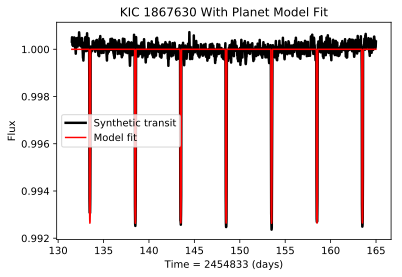

In [354]:
lc_transit = lc_transit.normalize()
plt.plot(lc_transit.time, lc_transit.flux, label='Synthetic transit', color='k', lw='2.5')
plt.plot(lc_transit.time, new_fit, label = 'Model fit', color='r')
plt.legend()
%config InlineBackend.figure_format = 'svg'
plt.title('KIC 1867630 With Planet Model Fit')
plt.xlabel('Time = 2454833 (days)')
plt.ylabel('Flux')
plt.savefig('/Users/sheilasagear/supernovae/plots/transit_modelfit')

In [ ]:
tpf = KeplerTargetPixelFile.from_archive(220381074) 
lc = tpf.to_lightcurve(aperture_mask='all') 

In [ ]:
model = inj.SupernovaModel(T0=2600, source='hsiao', 
                           bandpass='kepler', z=0.5, amplitude=2.e-7)
lcinj = inj.inject(lc, model)

In [ ]:
model = inj.TransitModel()
model.add_star()
model.add_planet(period=5, rprs=0.08, T0=133.5)
lcinj = inj.inject(lc, model)